In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from astropy.io import fits
from astropy import modeling
import scipy.integrate as integrate
from tqdm import tqdm

# 1. Calculate the standard deviation of CL windows

In [2]:
class CL_computation:
    def __init__(self,lam=[],width=[],std_dev=pd.DataFrame(),\
                 area=pd.DataFrame()):
        self.lam=lam
        self.width=width
        self.std_dev=std_dev
        self.area=area
        #self.flux_re=flux_re
        
    def wave_win(self,v):
        c=299792.458
        width=[]
        for j in range(len(self.lam)):
            width.append((v/c)*self.lam[j])
        print('widths are prepared:%s'%width)
        self.width=width
        return width
    
    def CL_comp_std_sn(self,lam_no_z,flux,mask,sn):
        da=[]
        for i in range(len(self.lam)):
            ind=np.where((lam_no_z>(self.lam[i]-self.width[i]/2))&(lam_no_z<(self.lam[i]+self.width[i]/2))&(mask==0),True,False)
            wave_window=lam_no_z[ind]
            #print(wave_window)
            flux_window=flux[ind]
            if len(wave_window)<3 or len(flux_window)<3:
                continue
            #
            window_min_flux=flux_window[np.where(wave_window==min(wave_window))]
            window_max_flux=flux_window[np.where(wave_window==max(wave_window))]
            k=(window_max_flux-window_min_flux)/(max(wave_window)-min(wave_window))
            b=window_min_flux-k*min(wave_window)
            window_number=len(wave_window)
            window_length=max(wave_window)-min(wave_window)
            def pseudo_con(x):
                y=k*x+b
                return y
            pseudo_range=pseudo_con(np.arange(min(wave_window),max(wave_window),window_length/window_number))
            flux_re=flux_window-pseudo_range[0:len(flux_window)]
            if sn==True:
                std=np.std(flux_re[flux_re>0])
                sn=np.mean(flux_window)/np.std(flux_window)
                da.append([self.lam[i],std,sn])
            else:
                std=np.std(flux_re[flux_re>0])
                sn=-99
                da.append([self.lam[i],std,sn])
        da=pd.DataFrame(da,columns=['wavename','stddev','SNR'])
        self.std_dev=da
        #self.flux_re=flux_re
        return(da)
        
    def CL_comp_area(self,lam_no_z,flux,mask,fit):
        dat=[]
        for i in range(len(self.lam)):
            #if self.lam[i]-self.width[i]/2>min(self.wave_window) and self.lam[i]+self.width[i]/2<max(self.wave_window):
            #ind1=np.where((lam_no_z>self.lam[i]-5)&(lam_no_z<self.lam[i]+5)&(mask==0),True,False)
            #else:
            ind1=np.where((lam_no_z>(self.lam[i]-self.width[i]/2))&(lam_no_z<(self.lam[i]+self.width[i]/2))&(mask==0),True,False)
            wave_window=lam_no_z[ind1]
            flux_window=flux[ind1]
            if len(wave_window)<3 or len(flux_window)<3 or len(wave_window)-len(flux_window)!=0:
                continue
            #
            window_min_flux=flux_window[np.where(wave_window==min(wave_window))]
            window_max_flux=flux_window[np.where(wave_window==max(wave_window))]
            k=(window_max_flux-window_min_flux)/(max(wave_window)-min(wave_window))
            b=window_min_flux-k*min(wave_window)
            window_number=len(wave_window)
            window_length=max(wave_window)-min(wave_window)
            def pseudo_con(x):
                y=k*x+b
                return y
            pseudo_range=pseudo_con(np.arange(min(wave_window),max(wave_window),window_length/window_number))
            flux_re=flux_window-pseudo_range[0:len(flux_window)]
            if fit==True:
                flux_center=np.max(flux_window)
                wave_center=wave_window[np.where(flux_window==flux_center)]
                g_init = modeling.models.Gaussian1D(amplitude=flux_center, mean=wave_center, stddev=10.)
                fit_g = modeling.fitting.LevMarLSQFitter()
                g = fit_g(g_init, wave_window, flux_window)
                flux_fitting=g(wave_window)
                #
                def f_test(n):
                    m=g(n)-pseudo_con(n)
                    return(m)
                area=integrate.quad(f_test,min(wave_window),max(wave_window))[0]
                area_err=integrate.quad(f_test,min(wave_window),max(wave_window))[1]
                dat.append([self.lam[i],area,area_err])
            else:
                area=np.sum(flux_re)
                dat.append([self.lam[i],area,0.0])
            #print("%s,%f,%f"%(i,SNR,area))
        cat=pd.DataFrame(dat,columns=['wavename','ar','ar_err'])
        self.area=cat
        return(cat)

In [3]:
path='/media/richard/Backup Plus/sdss_16_pair/'
path_catalog='/media/richard/Backup Plus/314kpair_DR16_Z_1.5_Nrich.csv'
#data=pd.read_csv(path_catalog,low_memory=False,chunksize=1000,skiprows=134000,names=pd.read_csv(path_catalog).columns)
data=pd.read_csv(path_catalog,low_memory=False,chunksize=1000)
chunks=[]

In [4]:
#cl_all=[3425.8,3758.9,3839.4,4412.5,5159.0,5302.9,5335.2,5426.6,5720.7,6087.0,6374.5,7005.8,7611.0,7891.8]
N=[1240,1486,1750]
CL=CL_computation(N,[])
WIDTH=CL.wave_win(10000)
f=open('/media/richard/Backup Plus/error_nrich.txt','a')
for chunk in data:
    for i in tqdm(chunk.index):
        hdu= fits.open(path+chunk.specname[i])
        try:
            spectra=hdu[1].data
            spectra_2=hdu[2].data
            Lam_no_z=(10**spectra['loglam'])/(spectra_2.Z+1)
            Flux=spectra['flux']
            MASK=spectra['and_mask']
            ca=CL.CL_comp_std_sn(Lam_no_z,Flux,MASK,True)
            #ca_area=CL.CL_comp_area(Lam_no_z,Flux,MASK,False)
            #ind_sn=np.where((Lam_no_z>6005)&(Lam_no_z<6035),True,False)
            #sn_con=Flux[ind_sn]
            for x in range(len(ca)):
                chunk.loc[chunk.specname==chunk.specname[i],'STD%d'%CL.std_dev['wavename'][x]]=CL.std_dev['stddev'][x]
                chunk.loc[chunk.specname==chunk.specname[i],'SNR%d'%CL.std_dev['wavename'][x]]=CL.std_dev['SNR'][x]
            #for xx in range(len(ca_area)):    
                #chunk.loc[chunk.specname==chunk.specname[i],'AREA%d'%CL.area['wavename'][xx]]=CL.area['ar'][xx]
                #chunk.loc[chunk.specname==chunk.specname[i],'SN_6020']=np.mean(sn_con)/np.std(sn_con)
        except TypeError:
            print('wrong:%s'%chunk.specname[i])
            f.write('%s'%chunk.specname[i])
            pass
        except Exception:
            print('wrong:%s'%chunk.specname[i])
            f.write('%s'%chunk.specname[i])
            pass
    chunks.append(chunk)
    print(max(chunk.index))
data2=pd.concat(chunks)
data2=data2.replace([np.inf, -np.inf],-999)
data2=data2.fillna(-999)
data2.to_csv('/media/richard/Backup Plus/314kpair_DR16_Z_1.5_Nrich.csv')

  0%|          | 0/1000 [00:00<?, ?it/s]

widths are prepared:[82.72389560914172, 99.1352490928908, 116.74743331935323]


 32%|███▏      | 323/1000 [00:31<00:39, 17.20it/s]/usr/lib/python3/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/lib/python3/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/1000 [00:00<?, ?it/s]

999


  0%|          | 0/1000 [00:00<?, ?it/s]

1999


 68%|██████▊   | 676/1000 [01:30<00:34,  9.41it/s]WARNING: File may have been truncated: actual file length (81623) is smaller than the expected size (161280) [astropy.io.fits.file]


wrong:spec-9158-57664-0694.fits


 68%|██████▊   | 682/1000 [01:31<00:37,  8.37it/s]

wrong:spec-9158-57664-0729.fits


  0%|          | 2/1000 [00:00<00:55, 17.93it/s]

2999


  0%|          | 2/1000 [00:00<01:00, 16.48it/s]

3999


  0%|          | 2/1000 [00:00<01:13, 13.58it/s]

4999


  0%|          | 0/1000 [00:00<?, ?it/s]

5999


  0%|          | 2/1000 [00:00<01:14, 13.46it/s]

6999


  0%|          | 0/1000 [00:00<?, ?it/s]

7999


  0%|          | 2/1000 [00:00<01:04, 15.47it/s]

8999


  0%|          | 2/1000 [00:00<00:52, 18.95it/s]

9999


  0%|          | 0/1000 [00:00<?, ?it/s]

10999


  0%|          | 0/1000 [00:00<?, ?it/s]

11999


 98%|█████████▊| 981/1000 [01:45<00:02,  9.11it/s]

wrong:spec-9158-57664-0652.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

12999


  1%|▏         | 13/1000 [00:01<01:51,  8.89it/s]

wrong:spec-9158-57664-0714.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

13999


  0%|          | 2/1000 [00:00<01:06, 14.91it/s]

14999


  0%|          | 1/1000 [00:00<02:10,  7.65it/s]

15999


  0%|          | 1/1000 [00:00<02:43,  6.11it/s]

16999


  0%|          | 1/1000 [00:00<02:28,  6.70it/s]

17999


  0%|          | 1/1000 [00:00<02:25,  6.89it/s]

18999


  0%|          | 2/1000 [00:00<01:20, 12.43it/s]

19999


  0%|          | 0/1000 [00:00<?, ?it/s]

20999


  0%|          | 0/1000 [00:00<?, ?it/s]

21999


  0%|          | 1/1000 [00:00<02:51,  5.82it/s]

22999


  0%|          | 0/1000 [00:00<?, ?it/s]

23999


  0%|          | 1/1000 [00:00<02:14,  7.41it/s]

24999


  0%|          | 0/1000 [00:00<?, ?it/s]

25999


  0%|          | 1/1000 [00:00<02:44,  6.07it/s]

26999


  0%|          | 0/1000 [00:00<?, ?it/s]

27999


  0%|          | 0/1000 [00:00<?, ?it/s]

28999


  0%|          | 0/1000 [00:00<?, ?it/s]

29999


 31%|███▏      | 314/1000 [00:43<02:02,  5.59it/s]

wrong:spec-7340-57196-0662.fits


 92%|█████████▏| 915/1000 [02:32<00:14,  5.68it/s]

wrong:spec-7340-57196-0687.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

30999


  0%|          | 0/1000 [00:00<?, ?it/s]

31999


  0%|          | 1/1000 [00:00<01:59,  8.38it/s]

32999


  0%|          | 1/1000 [00:00<01:49,  9.11it/s]

33999


  0%|          | 1/1000 [00:00<02:20,  7.11it/s]

34999


  0%|          | 0/1000 [00:00<?, ?it/s]

35999


  0%|          | 1/1000 [00:00<02:25,  6.85it/s]

36999


  0%|          | 0/1000 [00:00<?, ?it/s]

37999


 96%|█████████▌| 961/1000 [01:50<00:04,  8.37it/s]

wrong:spec-6737-56365-0330.fits


 97%|█████████▋| 968/1000 [01:50<00:03,  8.47it/s]

wrong:spec-6737-56365-0464.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

38999


  5%|▍         | 47/1000 [00:05<01:53,  8.39it/s]

wrong:spec-6737-56365-0228.fits


  5%|▌         | 51/1000 [00:06<01:45,  9.00it/s]

wrong:spec-6737-56365-0198.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

39999


  0%|          | 1/1000 [00:00<02:52,  5.78it/s]

40999


  0%|          | 1/1000 [00:00<02:19,  7.14it/s]

41999


  0%|          | 1/1000 [00:00<02:10,  7.68it/s]

42999


  0%|          | 0/1000 [00:00<?, ?it/s]

43999


  0%|          | 0/1000 [00:00<?, ?it/s]

44999


  0%|          | 0/1000 [00:00<?, ?it/s]

45999


  0%|          | 0/1000 [00:00<?, ?it/s]

46999


  0%|          | 2/1000 [00:00<01:14, 13.32it/s]

47999


  0%|          | 1/1000 [00:00<02:35,  6.42it/s]

48999


  0%|          | 1/1000 [00:00<02:25,  6.86it/s]

49999


  0%|          | 0/1000 [00:00<?, ?it/s]

50999


  0%|          | 0/1000 [00:00<?, ?it/s]

51999


  0%|          | 0/1000 [00:00<?, ?it/s]

52999


  0%|          | 0/1000 [00:00<?, ?it/s]

53999


  0%|          | 0/1000 [00:00<?, ?it/s]

54999


  0%|          | 0/1000 [00:00<?, ?it/s]

55999


  0%|          | 0/1000 [00:00<?, ?it/s]

56999


  0%|          | 0/1000 [00:00<?, ?it/s]

57999


  0%|          | 1/1000 [00:00<02:28,  6.75it/s]

58999


  0%|          | 0/1000 [00:00<?, ?it/s]

59999


  0%|          | 1/1000 [00:00<01:59,  8.38it/s]

60999


  0%|          | 0/1000 [00:00<?, ?it/s]

61999


  0%|          | 1/1000 [00:00<01:56,  8.56it/s]

62999


  0%|          | 1/1000 [00:00<02:42,  6.13it/s]

63999


  0%|          | 0/1000 [00:00<?, ?it/s]

64999


  0%|          | 1/1000 [00:00<02:43,  6.11it/s]

65999


  0%|          | 0/1000 [00:00<?, ?it/s]

66999


  0%|          | 1/1000 [00:00<01:43,  9.66it/s]

67999


  0%|          | 0/1000 [00:00<?, ?it/s]

68999


  0%|          | 0/1000 [00:00<?, ?it/s]

69999


 67%|██████▋   | 670/1000 [01:38<00:42,  7.75it/s]

wrong:spec-3683-55178-0784.fits


  0%|          | 1/1000 [00:00<02:00,  8.27it/s]

70999


  0%|          | 0/1000 [00:00<?, ?it/s]

71999


  0%|          | 1/1000 [00:00<01:45,  9.48it/s]

72999


  0%|          | 1/1000 [00:00<02:00,  8.26it/s]

73999


  0%|          | 0/1000 [00:00<?, ?it/s]

74999


  0%|          | 1/1000 [00:00<02:09,  7.74it/s]

75999


  0%|          | 1/1000 [00:00<01:48,  9.23it/s]

76999


  0%|          | 1/1000 [00:00<01:53,  8.81it/s]

77999


  0%|          | 1/1000 [00:00<01:50,  9.08it/s]

78999


  0%|          | 1/1000 [00:00<02:13,  7.49it/s]

79999


  0%|          | 1/1000 [00:00<02:05,  7.94it/s]

80999


  0%|          | 1/1000 [00:00<01:53,  8.80it/s]

81999


  0%|          | 0/1000 [00:00<?, ?it/s]

82999


  0%|          | 0/1000 [00:00<?, ?it/s]

83999


  4%|▍         | 41/1000 [00:06<02:14,  7.13it/s]

wrong:spec-9158-57664-0716.fits


  4%|▍         | 43/1000 [00:06<02:11,  7.29it/s]

wrong:spec-9158-57664-0650.fits


  4%|▍         | 45/1000 [00:07<02:06,  7.55it/s]

wrong:spec-9158-57664-0644.fits


 15%|█▍        | 148/1000 [00:23<01:56,  7.34it/s]

wrong:spec-9158-57664-0677.fits


 15%|█▌        | 150/1000 [00:23<01:56,  7.32it/s]

wrong:spec-9158-57664-0625.fits


 15%|█▌        | 152/1000 [00:23<01:52,  7.51it/s]

wrong:spec-9158-57664-0706.fits


 21%|██        | 209/1000 [00:33<01:51,  7.10it/s]

wrong:spec-9158-57664-0739.fits


 21%|██        | 211/1000 [00:33<01:43,  7.62it/s]

wrong:spec-9158-57664-0731.fits


 22%|██▏       | 215/1000 [00:34<01:47,  7.27it/s]

wrong:spec-9158-57664-0684.fits


 22%|██▏       | 219/1000 [00:34<01:49,  7.15it/s]

wrong:spec-9158-57664-0620.fits


 24%|██▍       | 243/1000 [00:38<01:45,  7.17it/s]

wrong:spec-9158-57664-0751.fits


  0%|          | 1/1000 [00:00<01:56,  8.57it/s]

84999


  0%|          | 1/1000 [00:00<02:15,  7.39it/s]

85999


  0%|          | 1/1000 [00:00<02:07,  7.82it/s]

86999


  0%|          | 0/1000 [00:00<?, ?it/s]

87999


  0%|          | 1/1000 [00:00<01:55,  8.65it/s]

88999


  0%|          | 0/1000 [00:00<?, ?it/s]

89999


  0%|          | 0/1000 [00:00<?, ?it/s]

90999


  0%|          | 1/1000 [00:00<01:56,  8.54it/s]

91999


  0%|          | 0/1000 [00:00<?, ?it/s]

92999


  0%|          | 0/1000 [00:00<?, ?it/s]

93999


  0%|          | 0/1000 [00:00<?, ?it/s]

94999


  0%|          | 0/1000 [00:00<?, ?it/s]

95999


  0%|          | 1/1000 [00:00<02:01,  8.20it/s]

96999


  0%|          | 0/1000 [00:00<?, ?it/s]

97999


  0%|          | 1/1000 [00:00<02:00,  8.32it/s]

98999


  0%|          | 0/1000 [00:00<?, ?it/s]

99999


  0%|          | 1/1000 [00:00<02:17,  7.25it/s]

100999


  0%|          | 0/1000 [00:00<?, ?it/s]

101999


  0%|          | 1/1000 [00:00<02:25,  6.86it/s]

102999


  0%|          | 1/1000 [00:00<02:05,  7.93it/s]

103999


  0%|          | 0/1000 [00:00<?, ?it/s]

104999


  0%|          | 0/1000 [00:00<?, ?it/s]

105999


  0%|          | 0/1000 [00:00<?, ?it/s]

106999


  0%|          | 1/1000 [00:00<02:07,  7.82it/s]

107999


  0%|          | 1/1000 [00:00<02:08,  7.79it/s]

108999


  0%|          | 1/1000 [00:00<02:20,  7.10it/s]

109999


  0%|          | 0/1000 [00:00<?, ?it/s]

110999


  0%|          | 0/1000 [00:00<?, ?it/s]

111999


  0%|          | 0/1000 [00:00<?, ?it/s]

112999


  0%|          | 1/1000 [00:00<02:21,  7.06it/s]

113999


  0%|          | 1/1000 [00:00<02:13,  7.48it/s]

114999


  0%|          | 1/1000 [00:00<02:53,  5.75it/s]

115999


  0%|          | 1/1000 [00:00<02:13,  7.49it/s]

116999


  0%|          | 0/1000 [00:00<?, ?it/s]

117999


  0%|          | 1/1000 [00:00<02:13,  7.48it/s]

118999


  0%|          | 1/1000 [00:00<02:13,  7.47it/s]

119999


  0%|          | 0/1000 [00:00<?, ?it/s]

120999


  0%|          | 1/1000 [00:00<02:32,  6.57it/s]

121999


  0%|          | 1/1000 [00:00<02:17,  7.24it/s]

122999


  0%|          | 1/1000 [00:00<02:13,  7.50it/s]

123999


  0%|          | 1/1000 [00:00<02:18,  7.21it/s]

124999


  0%|          | 1/1000 [00:00<02:15,  7.38it/s]

125999


  0%|          | 1/1000 [00:00<02:15,  7.36it/s]

126999


  0%|          | 0/1000 [00:00<?, ?it/s]

127999


  0%|          | 1/1000 [00:00<02:20,  7.13it/s]

128999


  0%|          | 1/1000 [00:00<02:23,  6.97it/s]

129999


  0%|          | 1/1000 [00:00<02:32,  6.55it/s]

130999


  0%|          | 0/1000 [00:00<?, ?it/s]

131999


  0%|          | 1/1000 [00:00<02:33,  6.50it/s]

132999


  0%|          | 1/1000 [00:00<02:21,  7.06it/s]

133999


  0%|          | 0/1000 [00:00<?, ?it/s]

134999


  0%|          | 1/1000 [00:00<02:24,  6.93it/s]

135999


  0%|          | 0/1000 [00:00<?, ?it/s]

136999


  0%|          | 0/1000 [00:00<?, ?it/s]

137999


  0%|          | 1/1000 [00:00<02:42,  6.15it/s]

138999


  0%|          | 1/1000 [00:00<02:45,  6.05it/s]

139999


  0%|          | 0/1000 [00:00<?, ?it/s]

140999


  0%|          | 1/1000 [00:00<02:46,  5.99it/s]

141999


  0%|          | 1/1000 [00:00<02:29,  6.69it/s]

142999


  0%|          | 1/1000 [00:00<02:29,  6.70it/s]

143999


  0%|          | 0/1000 [00:00<?, ?it/s]

144999


  0%|          | 1/1000 [00:00<02:31,  6.60it/s]

145999


  0%|          | 0/1000 [00:00<?, ?it/s]

146999


  0%|          | 1/1000 [00:00<02:46,  6.00it/s]

147999


  0%|          | 0/1000 [00:00<?, ?it/s]

148999


  0%|          | 1/1000 [00:00<02:31,  6.58it/s]

149999


  0%|          | 1/1000 [00:00<02:33,  6.49it/s]

150999


  0%|          | 0/1000 [00:00<?, ?it/s]

151999


  0%|          | 0/1000 [00:00<?, ?it/s]

152999


  0%|          | 1/1000 [00:00<02:35,  6.42it/s]

153999


  0%|          | 0/1000 [00:00<?, ?it/s]

154999


  0%|          | 0/1000 [00:00<?, ?it/s]

155999


  0%|          | 0/1000 [00:00<?, ?it/s]

156999


  0%|          | 0/1000 [00:00<?, ?it/s]

157999


  0%|          | 1/1000 [00:00<02:36,  6.40it/s]

158999


  0%|          | 0/1000 [00:00<?, ?it/s]

159999


  0%|          | 0/1000 [00:00<?, ?it/s]

160999


  0%|          | 1/1000 [00:00<02:50,  5.87it/s]

161999


  0%|          | 1/1000 [00:00<02:38,  6.32it/s]

162999


  0%|          | 0/1000 [00:00<?, ?it/s]

163999


  0%|          | 0/1000 [00:00<?, ?it/s]

164999


  0%|          | 0/1000 [00:00<?, ?it/s]

165999


  0%|          | 1/1000 [00:00<02:38,  6.29it/s]

166999


  0%|          | 1/1000 [00:00<02:41,  6.20it/s]

167999


  0%|          | 0/1000 [00:00<?, ?it/s]

168999


  0%|          | 1/1000 [00:00<02:40,  6.23it/s]

169999


  0%|          | 1/1000 [00:00<02:40,  6.23it/s]

170999


  0%|          | 0/1000 [00:00<?, ?it/s]

171999


  0%|          | 0/1000 [00:00<?, ?it/s]

172999


  0%|          | 0/1000 [00:00<?, ?it/s]

173999


  8%|▊         | 85/1000 [00:16<02:45,  5.52it/s]

wrong:spec-7340-57196-0685.fits


 30%|███       | 301/1000 [00:57<02:02,  5.68it/s]

wrong:spec-7340-57196-0692.fits


 38%|███▊      | 375/1000 [01:10<01:48,  5.77it/s]

wrong:spec-7340-57196-0699.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

174999


  0%|          | 0/1000 [00:00<?, ?it/s]

175999


  0%|          | 0/1000 [00:00<?, ?it/s]

176999


  0%|          | 1/1000 [00:00<02:40,  6.21it/s]

177999


  0%|          | 1/1000 [00:00<02:42,  6.13it/s]

178999


 20%|██        | 200/1000 [00:36<02:08,  6.20it/s]

wrong:spec-6737-56365-0154.fits


 20%|██        | 202/1000 [00:36<02:19,  5.72it/s]

wrong:spec-6737-56365-0170.fits


 20%|██        | 205/1000 [00:37<02:22,  5.60it/s]

wrong:spec-6737-56365-0176.fits


 21%|██        | 207/1000 [00:37<02:13,  5.93it/s]

wrong:spec-6737-56365-0236.fits


 21%|██        | 211/1000 [00:38<02:12,  5.94it/s]

wrong:spec-6737-56365-0296.fits


 21%|██▏       | 213/1000 [00:38<02:08,  6.11it/s]

wrong:spec-6737-56365-0314.fits


 22%|██▏       | 215/1000 [00:38<02:06,  6.19it/s]

wrong:spec-6737-56365-0317.fits


 22%|██▏       | 223/1000 [00:40<02:14,  5.79it/s]

wrong:spec-6737-56365-0460.fits


 22%|██▎       | 225/1000 [00:40<02:02,  6.31it/s]

wrong:spec-6737-56365-0486.fits


 94%|█████████▍| 940/1000 [02:53<00:10,  5.83it/s]

wrong:spec-7340-57196-0700.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

179999


  0%|          | 0/1000 [00:00<?, ?it/s]

180999


  0%|          | 0/1000 [00:00<?, ?it/s]

181999


 65%|██████▌   | 653/1000 [02:01<01:01,  5.65it/s]

wrong:spec-7340-57196-0694.fits


 72%|███████▏  | 724/1000 [02:14<00:48,  5.65it/s]

wrong:spec-7340-57196-0673.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

182999


  0%|          | 0/1000 [00:00<?, ?it/s]

183999


  0%|          | 1/1000 [00:00<02:41,  6.18it/s]

184999


  0%|          | 0/1000 [00:00<?, ?it/s]

185999


  0%|          | 0/1000 [00:00<?, ?it/s]

186999


  0%|          | 0/1000 [00:00<?, ?it/s]

187999


  0%|          | 0/1000 [00:00<?, ?it/s]

188999


 45%|████▍     | 447/1000 [01:23<01:39,  5.57it/s]

wrong:spec-7340-57196-0669.fits


 52%|█████▏    | 518/1000 [01:36<01:29,  5.41it/s]

wrong:spec-7340-57196-0676.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

189999


  0%|          | 0/1000 [00:00<?, ?it/s]

190999


  0%|          | 0/1000 [00:00<?, ?it/s]

191999


  0%|          | 0/1000 [00:00<?, ?it/s]

192999


  0%|          | 0/1000 [00:00<?, ?it/s]

193999


  0%|          | 0/1000 [00:00<?, ?it/s]

194999


  0%|          | 0/1000 [00:00<?, ?it/s]

195999


  0%|          | 0/1000 [00:00<?, ?it/s]

196999


  0%|          | 0/1000 [00:00<?, ?it/s]

197999


  0%|          | 0/1000 [00:00<?, ?it/s]

198999


  0%|          | 0/1000 [00:00<?, ?it/s]

199999


  0%|          | 0/1000 [00:00<?, ?it/s]

200999


 16%|█▌        | 159/1000 [00:29<02:29,  5.63it/s]

wrong:spec-7340-57196-0690.fits


 23%|██▎       | 230/1000 [00:42<02:18,  5.56it/s]

wrong:spec-7340-57196-0682.fits


 37%|███▋      | 371/1000 [01:08<01:46,  5.88it/s]

wrong:spec-7340-57196-0670.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

201999


  0%|          | 0/1000 [00:00<?, ?it/s]

202999


  0%|          | 0/1000 [00:00<?, ?it/s]

203999


 65%|██████▍   | 646/1000 [01:58<01:01,  5.76it/s]

wrong:spec-7340-57196-0680.fits


 72%|███████▏  | 717/1000 [02:11<00:50,  5.65it/s]

wrong:spec-7340-57196-0674.fits


 79%|███████▊  | 787/1000 [02:24<00:36,  5.81it/s]

wrong:spec-7340-57196-0681.fits


 86%|████████▌ | 859/1000 [02:36<00:24,  5.72it/s]

wrong:spec-7340-57196-0665.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

204999


  0%|          | 0/1000 [00:00<?, ?it/s]

205999


 93%|█████████▎| 926/1000 [02:50<00:12,  5.89it/s]

wrong:spec-7340-57196-0697.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

206999


 14%|█▍        | 139/1000 [00:25<02:30,  5.71it/s]

wrong:spec-7340-57196-0683.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

207999


  0%|          | 0/1000 [00:00<?, ?it/s]

208999


  0%|          | 0/1000 [00:00<?, ?it/s]

209999


  0%|          | 1/1000 [00:00<02:42,  6.14it/s]

210999


  0%|          | 1/1000 [00:00<02:47,  5.95it/s]

211999


  0%|          | 0/1000 [00:00<?, ?it/s]

212999


  0%|          | 0/1000 [00:00<?, ?it/s]

213999


  0%|          | 1/1000 [00:00<02:47,  5.95it/s]

214999


 95%|█████████▌| 951/1000 [02:51<00:08,  5.60it/s]

wrong:spec-7340-57196-0672.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

215999


  2%|▏         | 21/1000 [00:03<02:56,  5.55it/s]

wrong:spec-7340-57196-0663.fits


  9%|▉         | 91/1000 [00:16<02:37,  5.76it/s]

wrong:spec-7340-57196-0667.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

216999


  0%|          | 0/1000 [00:00<?, ?it/s]

217999


  0%|          | 0/1000 [00:00<?, ?it/s]

218999


  0%|          | 0/1000 [00:00<?, ?it/s]

219999


  0%|          | 0/1000 [00:00<?, ?it/s]

220999


  0%|          | 0/1000 [00:00<?, ?it/s]

221999


  0%|          | 0/1000 [00:00<?, ?it/s]

222999


  0%|          | 0/1000 [00:00<?, ?it/s]

223999


  0%|          | 0/1000 [00:00<?, ?it/s]

224999


  0%|          | 0/1000 [00:00<?, ?it/s]

225999


  0%|          | 0/1000 [00:00<?, ?it/s]

226999


  0%|          | 0/1000 [00:00<?, ?it/s]

227999


  0%|          | 0/1000 [00:00<?, ?it/s]

228999


  0%|          | 0/1000 [00:00<?, ?it/s]

229999


  0%|          | 0/1000 [00:00<?, ?it/s]

230999


 10%|▉         | 96/1000 [00:20<02:58,  5.07it/s]

wrong:spec-9158-57664-0641.fits


  0%|          | 0/1000 [00:00<?, ?it/s]

231999


  0%|          | 0/1000 [00:00<?, ?it/s]

232999


  0%|          | 0/1000 [00:00<?, ?it/s]

233999


  0%|          | 0/1000 [00:00<?, ?it/s]

234999


  0%|          | 0/1000 [00:00<?, ?it/s]

235999


  0%|          | 0/958 [00:00<?, ?it/s]

236999


100%|██████████| 958/958 [03:27<00:00,  4.61it/s]


237957


,wavename,stddev,SNR
0,1240,1.531635,0.645584
1,1486,0.464944,-99.000000
2,1750,0.140363,-99.000000


In [10]:
data2=pd.concat(chunks)
data2=data2.replace([np.inf, -np.inf],-999)
data2=data2.fillna(-999)
data2.to_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12_134.csv')

# 2. Count the CLs of which std >1,3,5,10

In [28]:
data2=pd.read_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12.csv',low_memory=False)
data2.columns[114:128]

Index(['STD3426', 'STD3758', 'STD3839', 'STD4414', 'STD5160', 'STD5304',
       'STD5335', 'STD5426', 'STD5720', 'STD6087', 'STD6375', 'STD7006',
       'STD7612', 'STD7894'],
      dtype='object')

In [30]:
for i in tqdm(data2.index):
    cut=data2.iloc[data2.index==data2.index[i],114:128]
    count_10=0
    count_5=0
    count_3=0
    count_2=0
    count_1=0
    for j in range(0,14):
        if float(cut.iloc[:,j])>=10 and float(cut.iloc[:,j])!=-999:
            count_10+=1
        if float(cut.iloc[:,j])>=5 and float(cut.iloc[:,j])!=-999:
            count_5+=1
        if float(cut.iloc[:,j]>=3) and float(cut.iloc[:,j])!=-999:
            count_3+=1
        if float(cut.iloc[:,j]>=2) and float(cut.iloc[:,j])!=-999:
            count_2+=1
        if float(cut.iloc[:,j]>=1) and float(cut.iloc[:,j])!=-999:
            count_1+=1
    data2.loc[data2.index==data2.index[i],'CL_10_COUNTS']=count_10
    data2.loc[data2.index==data2.index[i],'CL_5_COUNTS']=count_5
    data2.loc[data2.index==data2.index[i],'CL_3_COUNTS']=count_3
    data2.loc[data2.index==data2.index[i],'CL_2_COUNTS']=count_2
    data2.loc[data2.index==data2.index[i],'CL_1_COUNTS']=count_1

100%|██████████| 218174/218174 [32:12<00:00, 112.91it/s]


In [35]:
#len(data2[(data2.CL_5_COUNTS>1)&(data2.SN_6020>10)])
#data2.loc[data2.GroupID==69592]
len(data2[(data2.CL_1_COUNTS>2)&(data2.SN_6020>=15)])

44832

In [7]:
data2[0:134205].to_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12_134205.csv')

# 3. add the column of SUBCLASS and the BPT classification from PORTSMOUTH Group

In [5]:
path='/media/richard/Backup Plus/sdss_16_pair/'
data2=pd.read_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12.csv',low_memory=False)
#f=open('/media/richard/Backup Plus/e')
for i in tqdm(data2.index):
    if os.path.exists(path+'%s'%data2.specname[i])==True:
        try:
            hdu=fits.open(path+'%s'%data2.specname[i])
            da=hdu[2].data
            data2.loc[data2.index==data2.index[i],'SUBCLASS']=da['SUBCLASS']
        except IndexError:
            data2.loc[data2.index==data2.index[i],'SUBCLASS']=' '
            pass
        except Exception:
            data2.loc[data2.index==data2.index[i],'SUBCLASS']=' '
            pass
    else:
        print('fits not exist:%s'%data2.specname[i])
        #f.write('not exist:%s\n'%data2.specname[i])
#f.close()

100%|██████████| 218174/218174 [5:17:06<00:00, 11.47it/s]  


In [6]:
data2.to_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12.5.csv')

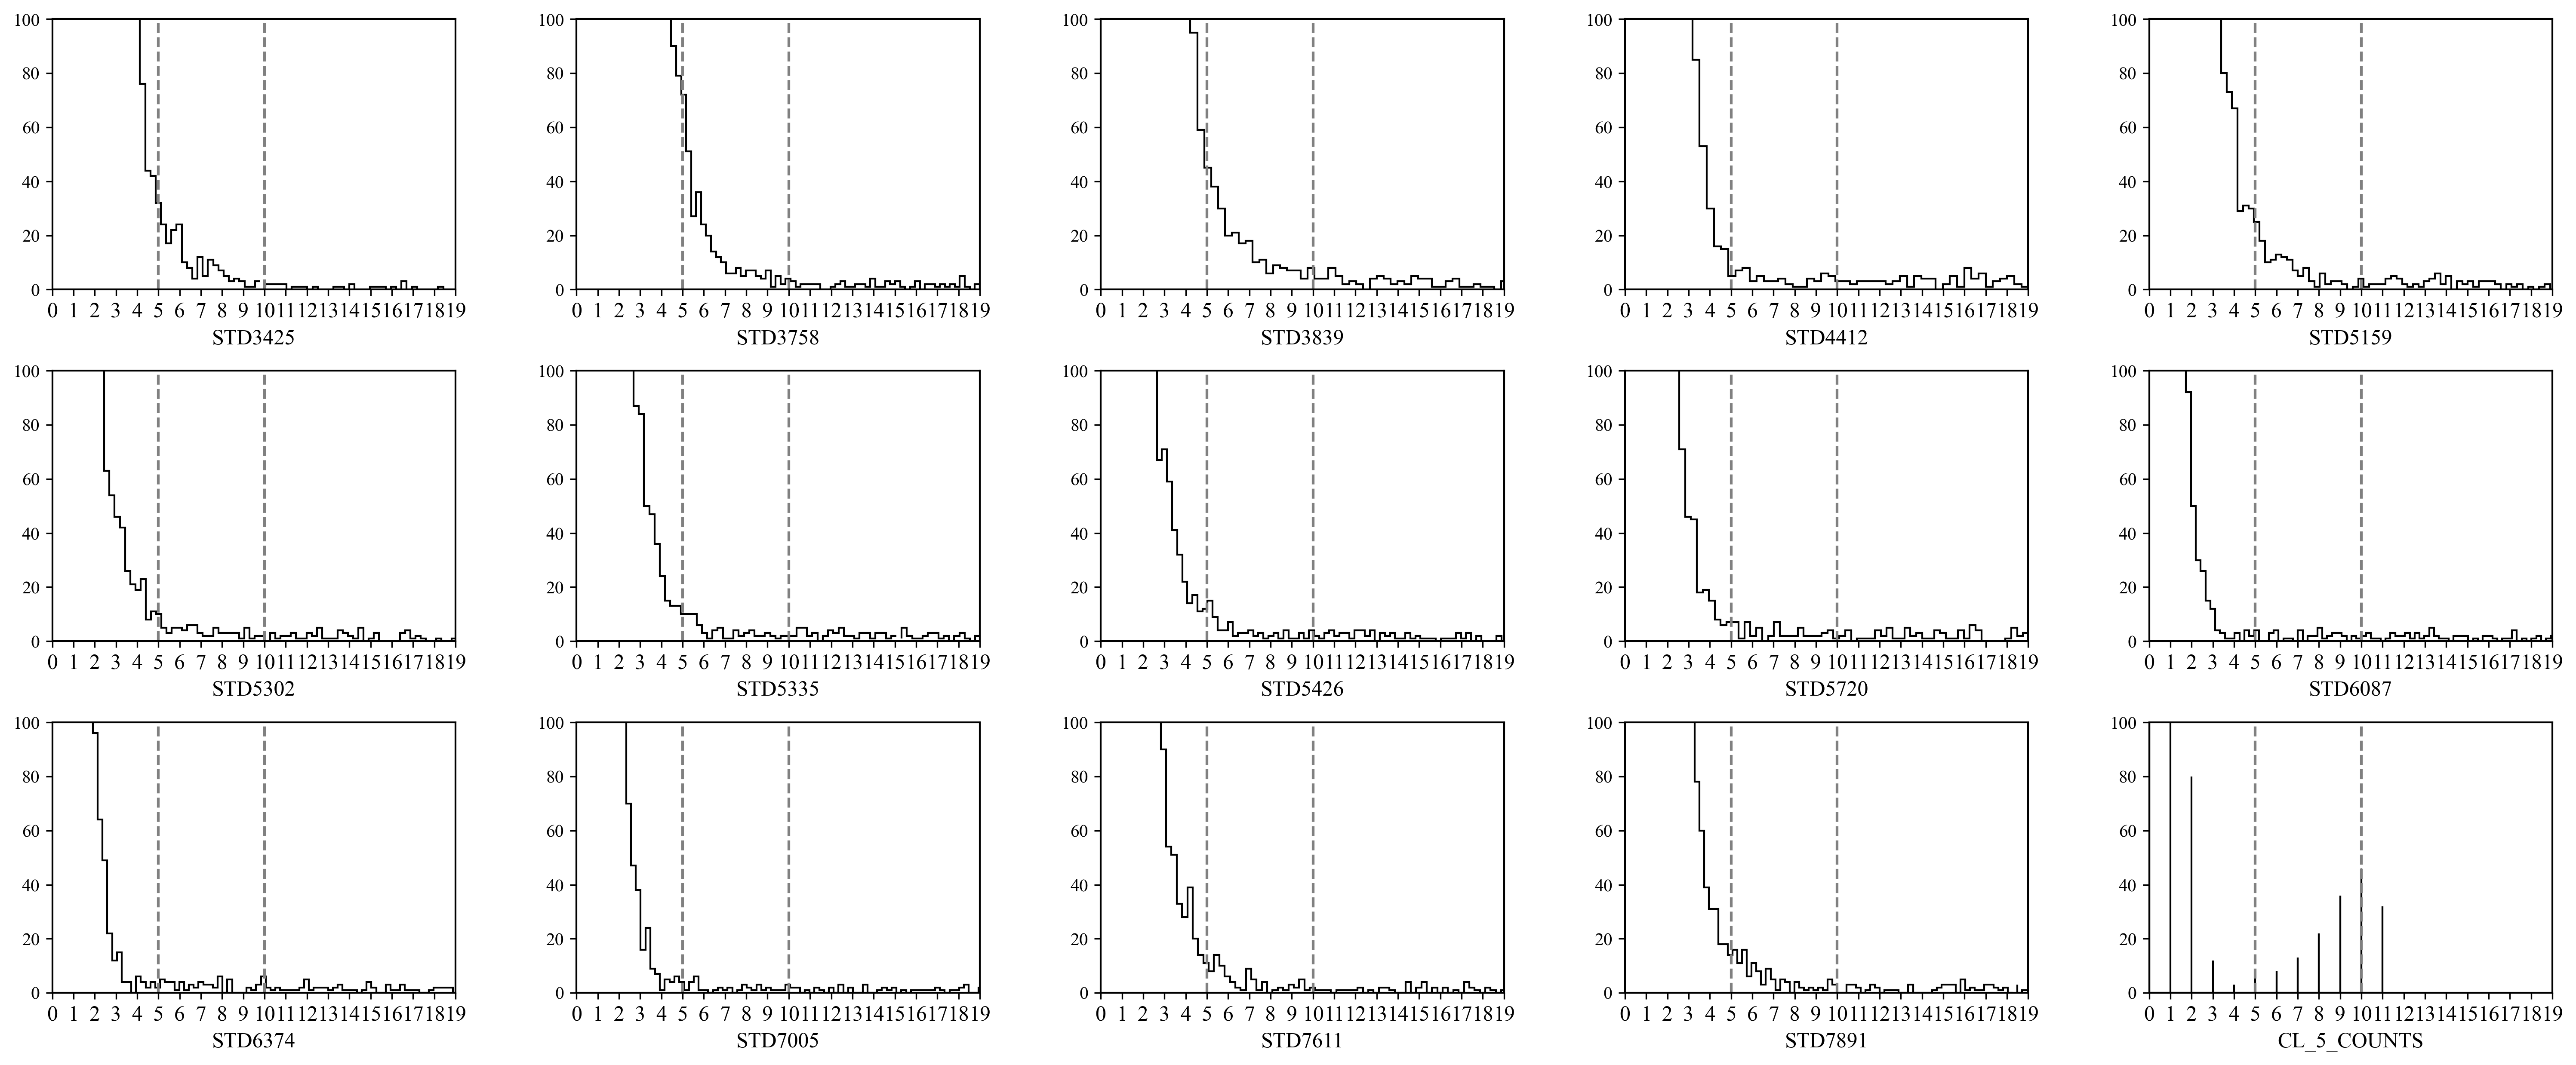

In [43]:
'''del mpl.font_manager.weight_dict['roman']
mpl.font_manager._rebuild()'''
m=1
plt.figure(dpi=300,figsize=(25,10))
for i in range(121,136):
    sn=data2['%s'%data2.columns[i]]
    sn=sn.astype(float)
    sn[np.isinf(sn)]=999
    mpl.rcParams['agg.path.chunksize']=1000
    mpl.rcParams['font.serif']='Times New Roman'
    mpl.rc('font',family='Times New Roman')
    ax=plt.subplot(3,5,m)
    civ=ax.hist(x=sn,bins=5000,color='black',alpha=1,rwidth=1,linewidth=1,histtype='step')
    ax.set_xlabel(r'%s'%str(data2.columns[i]),fontsize=12)
    ax.set_xlim(0,15)
    ax.set_ylim(0,100)
    ax.set_xticks(np.arange(0,20,1))
    plt.xticks(fontsize=12)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    #ax.set_yticks(np.arange(0,10000,1000))
    ax.axvline(x=10,ls='--',color='gray')
    ax.axvline(x=5,ls='--',color='gray')
    m+=1
'''
ax1=plt.subplot(3,5,15)
ax1.hist(x=data2.CL_5_COUNTS,bins='auto',color='red',alpha=1,rwidth=0.5,linewidth=1,histtype='step')
ax1.set_xlabel(r'CL_std-deviation>5',fontsize=12)
ax1.set_xlim(0,5)
ax1.set_ylim(0,10000)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['top'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['right'].set_linewidth(1)
ax1.axvline(x=1,ls='--',color='gray')
ax1.axvline(x=1,ls='--',color='gray')
'''

'''    
sn=data2['STD3426']
sn=sn.astype(float)
sn[np.isinf(sn)]=999
mpl.rcParams['agg.path.chunksize']=1000
mpl.rcParams['font.serif']='Times New Roman'
mpl.rc('font',family='Times New Roman')
ax=plt.subplot(3,4,8)
civ=ax.hist(x=sn,bins=6000,color='black',alpha=1,rwidth=1,linewidth=1,histtype='step')
ax.set_xlabel((r'STD3426'),fontsize=10)
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,10,1))
plt.xticks(fontsize=8)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.set_ylim(0,4000)
#ax.set_yticks(np.arange(0,10000,1000))
ax.axvline(x=10,ls='--',color='gray')
'''
'''
sn=data2['STD7006']
sn=sn.astype(float)
sn[np.isinf(sn)]=999
mpl.rcParams['agg.path.chunksize']=1000
mpl.rcParams['font.serif']='Times New Roman'
mpl.rc('font',family='Times New Roman')
ax=plt.subplot(3,4,9)
civ=ax.hist(x=sn,bins='auto',color='black',alpha=1,rwidth=1,linewidth=1,histtype='step')
ax.set_xlabel((r'STD7006'),fontsize=10)
ax.set_xlim(0,40)
ax.set_xticks(np.arange(0,40,5))
plt.xticks(fontsize=8)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.set_ylim(0,15000)
#ax.set_yticks(np.arange(0,10000,1000))
ax.axvline(x=10,ls='--',color='gray')

sn=data2['STD7612']
sn=sn.astype(float)
sn[np.isinf(sn)]=999
mpl.rcParams['agg.path.chunksize']=1000
mpl.rcParams['font.serif']='Times New Roman'
mpl.rc('font',family='Times New Roman')
ax=plt.subplot(3,4,10)
civ=ax.hist(x=sn,bins=1000,color='black',alpha=1,rwidth=1,linewidth=1,histtype='step')
ax.set_xlabel((r'STD7612'),fontsize=10)
ax.set_xlim(0,30)
ax.set_xticks(np.arange(0,30,5))
plt.xticks(fontsize=8)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.set_ylim(0,30000)
#ax.set_yticks(np.arange(0,10000,1000))
ax.axvline(x=10,ls='--',color='gray')
'''
'''
sn=data2['STD7894']
sn=sn.astype(float)
sn[np.isinf(sn)]=999
mpl.rcParams['agg.path.chunksize']=1000
mpl.rcParams['font.serif']='Times New Roman'
mpl.rc('font',family='Times New Roman')
ax=plt.subplot(3,4,11)
civ=ax.hist(x=sn,bins=1000,color='black',alpha=1,rwidth=1,linewidth=1,histtype='step')
ax.set_xlabel((r'STD7894'),fontsize=10)
ax.set_xlim(0,30)
ax.set_xticks(np.arange(0,30,5))
plt.xticks(fontsize=8)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.set_ylim(0,15000)
#ax.set_yticks(np.arange(0,10000,1000))
ax.axvline(x=10,ls='--',color='gray')
'''
plt.subplots_adjust(wspace=0.3,hspace=0.3)
plt.savefig('/media/richard/Backup Plus/std_star_Fo_FHIL_distribution.png')
plt.show()

# 4. test of Gaussian fit from Astropy

[38.41657684397117, 44.170557486139295, 53.07671882792995, 53.38693343646423, 54.29756341635519, 60.912139424134544, 63.79413320664658, 34.28371770446607, 70.1085015287476, 76.17269677945, 78.99464902482637]
flux_re:[ 4.32282832e-07 -2.85194043e-02  1.02160360e+00  9.36426930e-01
  2.76932324e-01  8.16872952e-01  1.23840156e+00  1.03654665e+00
  1.09551594e+00  1.58510216e-01  3.00809662e-01  1.70533569e+00
  1.13586222e+00  3.39254993e-01  1.29731887e+00  9.54547130e-01
  8.71046062e-01  9.16786937e-01 -5.08022248e-01 -1.09319356e-01
  1.19619494e-01 -1.32017217e-01  7.06765159e-02  4.13733942e-01
  1.24996115e+00  1.50186353e+00  1.54856046e-01 -7.07872755e-01
 -2.19856356e-01  5.68538843e-01 -3.20501621e-02 -9.22925708e-01
  4.10347337e-02 -8.90871803e-02  4.21484093e-01  2.99995793e-01
 -5.85015070e-03]
SNR:0.487975
flux_mean:0.701612
flux_std:0.487975
(28.176487731727086, 3.0854710437496605e-07)


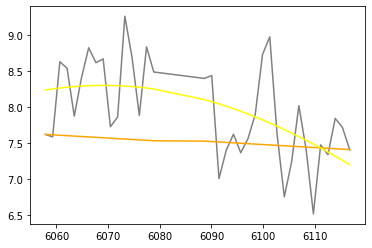

In [253]:
ind = np.where((lam_no_z>(WAVE[i]-WIDTH[i]/2))&(lam_no_z<(WAVE[i]+WIDTH[i]/2))&(spectra['and_mask']==0),True,False)
wave_window=lam_no_z[ind]
flux=spectra['flux'][ind]
if WAVE[i]-5>min(wave_window) and WAVE[i]+5<max(wave_window):
    ind1=np.where((lam_no_z>WAVE[i]-5)&(lam_no_z<WAVE[i]+5)&(spectra['and_mask']==0))
else:
    ind1=ind
flux_center=np.max(spectra['flux'][ind1])
wave_center=wave_window[np.where(flux==flux_center)]
#
window_min_flux=flux[np.where(wave_window==min(wave_window))]
window_max_flux=flux[np.where(wave_window==max(wave_window))]
k=(window_max_flux-window_min_flux)/(max(wave_window)-min(wave_window))
b=window_min_flux-k*min(wave_window)
window_number=len(wave_window)
window_length=max(wave_window)-min(wave_window)

def pseudo_con(x):
    y=k*x+b
    return y
pseudo_range=pseudo_con(np.arange(min(wave_window),max(wave_window),window_length/window_number))
flux_re=flux-pseudo_range[0:len(flux)]
SNR=np.std(flux_re[flux_re>0])
#
g_init = modeling.models.Gaussian1D(amplitude=flux_center, mean=wave_center, stddev=10.)
fit_g = modeling.fitting.LevMarLSQFitter()
g = fit_g(g_init, wave_window, flux)
flux_fitting=g(wave_window)
def f_test(n):
    m=g(n)-pseudo_con(n)
    return(m)
area=integrate.quad(f_test,min(wave_window),max(wave_window))
#snr=area/np.std(flux_re)
print("flux_re:%s\nSNR:%f\nflux_mean:%f\nflux_std:%f"%(flux_re,SNR,np.mean(flux_re[flux_re>0]),np.std(flux_re[flux_re>0])))
plt.plot(wave_window,flux,color='gray')
plt.plot(wave_window,pseudo_range,color='orange')
#plt.plot(wave_window,flux_re,color='red')
plt.plot(wave_window,g(wave_window),color='yellow')
print(area)

In [ ]:
for chunk in data:
    for i in tqdm(chunk.index):
        spectra = fits.open(path+chunk.specname[i])[1].data
        lam_no_z=(10**spectra['loglam'])/(chunk.Z[i]+1)
        for x in range(len(WAVE)):
            ind = np.where((lam_no_z>(WAVE[x]-WIDTH[x]/2))&(lam_no_z<(WAVE[x]+WIDTH[x]/2))&(spectra['and_mask']==0),True,False)
            flux = spectra['flux'][ind]
            if len(flux)<=2:
                chunk.loc[chunk.specname==chunk.specname[i],'SN%d'%WAVE[x]]=-999
                continue
            wave_window=lam_no_z[ind]
            #,
            window_min_flux=flux[np.where(wave_window==min(wave_window))]
            window_max_flux=flux[np.where(wave_window==max(wave_window))]
            k=(window_max_flux-window_min_flux)/(max(wave_window)-min(wave_window))
            b=window_min_flux-k*min(wave_window)
            pseudo_con_line=k*x+b
            window_number=len(wave_window)
            window_length=max(wave_window)-min(wave_window)
            pseudo_con=k*(np.arange(min(wave_window),max(wave_window),window_length/window_number))+b
            #,
            flux_re=flux-pseudo_con[0:len(flux)]
            chunk.loc[chunk.specname==chunk.specname[i],'SN%d'%WAVE[x]]=np.mean(flux_re)/np.std(flux_re)
            #,
            #g_init = modeling.models.Gaussian1D(amplitude=1., mean=0, stddev=1.),
            #fit_g = modeling.fitting.LevMarLSQFitter(),
            #g = fit_g(g_init, wave_window, flux),
            #flux_fitting=g(wave_window),
            #area=integrate.quad(g-pseudo_con_line,min(wave_window),max(wave_window)),
            #snr=area/np.std(flux_re),
            #print("%f,%f,%f,%f,%f"%(np.median(flux_re),np.mean(flux_re),np.std(flux_re),np.mean(flux_re)/np.std(flux_re),np.mean(flux)/np.std(flux_re)))
    chunks.append(chunk)
    print(max(chunk.index))
data2=pd.concat(chunks)
data2=data2.replace([np.inf, -np.inf],-999)
data2=data2.fillna(-999)
data2.to_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v8_star_fo_in_pair.csv')

13.064793

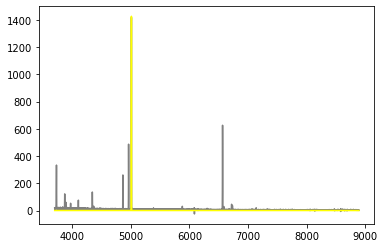

In [184]:
l=lam_no_z
f=spectra['flux']
ind=np.where((l>5006)&(l<5008))
g_init = modeling.models.Gaussian1D(amplitude=np.mean(f[ind]), mean=5007, stddev=5.)
fit_g = modeling.fitting.LevMarLSQFitter()
g = fit_g(g_init, l, f)
flux_fitting=g(l)
plt.plot(l,f,color='gray')
#plt.plot(wave_window,flux_re,color='red')
plt.plot(l,g(l),color='yellow')
plt.xlim(5000,5020)

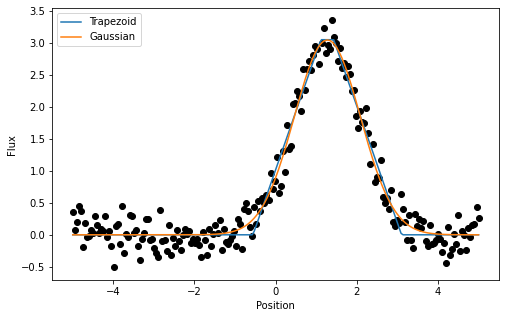

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.integrate as integrate
# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5,
                            bounds={"x_0": (-5., 5.)})
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=5., mean=3, stddev=2.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, t(x), label='Trapezoid')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)

In [78]:
integrate.quad(g,0,5)

(5.849318113739489, 6.885207176941062e-14)

In [83]:
print(g)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          1.0  0.0    1.0


# 5. Add the line area and line ew of HeII 4685

In [7]:
dat=pd.read_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12.5.csv')
path='/media/richard/Backup Plus/sdss_16_pair/'
f=open('/media/richard/Backup Plus/v12_0505.txt','a')
for i in tqdm(dat.index):
    try:
        if os.path.exists(path+'%s'%dat.specname[i])==True:
            hdu=fits.open(path+'%s'%dat.specname[i])
            data=hdu[3].data
            dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
            dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685_ERR']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
            dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
            dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685_ERR']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
        else:
            print('%s not exists'%dat.specname[i])
            f.write('%s not exists \n'%dat.specname[i])
    except IndexError:
        dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685']=-999
        dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685_ERR']=-999
        dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685']=-999
        dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685_ERR']=-999
        print('fits destoryed:%s'%dat.specname[i])
        f.write('fits destoryed:%s'%dat.specname[i])
        pass
    except Exception:
        pass
f.close()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
 62%|██████▏   | 134207/218174 [1:51:29<4:03:02,  5.76it/s]

fits destoryed:spec-7340-57196-0668.fits


 66%|██████▌   | 144263/218174 [2:04:08<1:34:19, 13.06it/s]

fits destoryed:spec-6737-56365-0212.fits


100%|██████████| 218174/218174 [4:23:19<00:00, 13.81it/s]  


In [8]:
dat.to_csv('/media/richard/Backup Plus/314kpair_DR16_final_Z_0.4_v12.5.csv')

In [ ]:
dat=pd.read_csv('/media/richard/Backup Plus/DR16_Z_1.5_final_2.0.csv')
path='/media/richard/Backup Plus/sdss_16_pair/'
f=open('/media/richard/Backup Plus/error_0511.txt','a')
for i in tqdm(dat.index):
    try:
        if os.path.exists(path+'%s'%dat.specname[i])==True:
            hdu=fits.open(path+'%s'%dat.specname[i])
            data=hdu[3].data
            dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
            dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685_ERR']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
            dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
            dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685_ERR']=data[data.LINENAME==b'He_II 4685   '].LINEAREA
        else:
            print('%s not exists'%dat.specname[i])
            f.write('%s not exists \n'%dat.specname[i])
    except IndexError:
        dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685']=-999
        dat.loc[dat.index==dat.index[i],'LINEAREA_HeII4685_ERR']=-999
        dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685']=-999
        dat.loc[dat.index==dat.index[i],'LINEEW_HeII4685_ERR']=-999
        print('fits destoryed:%s'%dat.specname[i])
        f.write('fits destoryed:%s'%dat.specname[i])
        pass
    except Exception:
        pass
f.close()